<a href="https://colab.research.google.com/github/SIshikawa1106/planner/blob/master/kShorterPath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import heapq

from logging import getLogger, StreamHandler, DEBUG, CRITICAL
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(CRITICAL)
logger.setLevel(CRITICAL)
logger.addHandler(handler)
logger.propagate = False

class Graph(object):
  def __init__(self):
    self.node_list = []
    self.link = {}
    self.route_links = {}
    self.route_link_costs = {}
    
  def add_node_edge(self, node, links, costs):
    assert len(links) == len(costs)
    self.node_list.append(node)
    index = len(self.node_list) - 1
    
    self.link[index] = {}
    
    for n, idx in enumerate(links):
      assert idx in self.link
      assert index not in self.link[idx]
      self.link[idx][index] = costs[n]
    
    return index

  def get_link_node_idx_list(self, index):
    assert index in self.link
    node_list = []
    for n in range(len(self.node_list)):
      assert n in self.link
      if n < index:
        if index in self.link[n]:
          node_list.append(n)
      elif n in self.link[index]:
        node_list.append(n)
    return node_list

  def get_link_cost(self, idx1, idx2):
    pre_idx = idx1 if idx1<idx2 else idx2
    nxt_idx = idx2 if idx1<idx2 else idx1

    assert pre_idx in self.link
    assert nxt_idx in self.link[pre_idx]

    return self.link[pre_idx][nxt_idx]

  def get_heuristic_cost(self, target_idx, goal_idx):
    assert max([target_idx, goal_idx]) < len(self.node_list)
    if target_idx in self.heuristic_costs:
      return self.heuristic_costs[target_idx]
    n1 = self.node_list[target_idx]
    n2 = self.node_list[goal_idx]
    if type(n1) != np.ndarray:
      n1 = np.array(n1)
    if type(n2) != np.ndarray:
      n2 = np.array(n2)
    cost = np.linalg.norm(n1 - n2)
    self.heuristic_costs[target_idx] = cost
    return cost

  def add_node_edge_and_find_shorter_path(self, node, links, costs, th_cost):
    # added node and get target index
    target_index = self.add_node_edge(node, links, costs)
    logger.debug("new node index = {}".format(target_index))
    logger.debug("links = {}".format(links))
    logger.debug("costs = {}".format(costs))

    goal_index = self.goal_index

    #calculation heuristic_cost
    heuristic_cost = self.get_heuristic_cost(target_index, goal_index)

    #init target_index route
    assert target_index not in self.route_links
    assert target_index not in self.route_link_costs
    self.route_links[target_index] = []
    self.route_link_costs[target_index] = []

    # added links
    for pre_node_idx, link_cost in zip(links, costs):
      # when pre_node_idx isn't included self.route_links, the pre_node_idx cost
      # form start_node_idx is over than lower threshold.
      if pre_node_idx not in self.route_links:
        assert pre_node_idx not in self.route_link_costs
        continue
      assert pre_node_idx in self.route_link_costs
      assert len(self.route_links) == len(self.route_link_costs)

      # getting pre node route from start node
      route_list = self.route_links[pre_node_idx]
      route_costs = self.route_link_costs[pre_node_idx]

      logger.debug("pre_node route list = {}".format(route_list))
      logger.debug("pre_node route costs = {}".format(route_costs))

      for n, (pre_route, pre_route_cost) in enumerate(zip(route_list, route_costs)):
        # make new route
        new_route = pre_route + [target_index]
        new_route_cost = pre_route_cost + link_cost
        new_route_est_cost = new_route_cost + heuristic_cost
        logger.debug("new_route={}".format(new_route))
        
        # registration route
        self.route_links[target_index].append(new_route)
        self.route_link_costs[target_index].append(new_route_cost)

        heapq.heappush(self.heap,
                   (new_route_est_cost,
                    target_index,
                    new_route,
                    new_route_cost)
                   )

    found_route_index_last = len(self.route_links[goal_index])

    route, costs = self.find_shorter_path(self.start_index, goal_index, th_cost, False)
   
    return self.route_links[goal_index][found_route_index_last:], \
           self.route_link_costs[goal_index][found_route_index_last:]

  def find_shorter_path(self, start_index, goal_index, th_cost, is_first=True):
    # init
    if is_first:
      self.heap = []
      self.route_links = {}
      self.route_link_costs = {}
      self.route_links[start_index] = []
      self.heuristic_costs = {}
      self.route_links[start_index] = [start_index]
      self.route_link_costs[start_index] = [0]
      self.start_index = start_index
      self.goal_index = goal_index
      current_route = [start_index]
      current_cost = 0
      est_cost = 0
      # (est_cost_to_goal, own index, route_index_from_start, cost_from_start)
      heapq.heappush(self.heap, (est_cost, start_index, current_route, current_cost))

    while len(self.heap)>0:
      # get min cost index
      est_cost, target_index, current_route, current_cost = heapq.heappop(self.heap)
      logger.debug(
          "\n\nest_cost={}\ntarget_index={}\ncurrent_route={}".format(
              est_cost, target_index, current_route)
      )
      #input()
      if est_cost > th_cost:
        continue
      if target_index == goal_index:
        continue
      
      # getting next node list
      link_node_idx_list = self.get_link_node_idx_list(target_index)

      for link_node_idx in link_node_idx_list:
        # skip when current route is included next node. 
        if link_node_idx in current_route:
          continue
        link_cost = self.get_link_cost(target_index, link_node_idx)
        heuristic_cost = 0
        if link_node_idx != goal_index:
          heuristic_cost = self.get_heuristic_cost(link_node_idx, goal_index)

        new_route = current_route + [link_node_idx]
        new_route_cost = current_cost + link_cost
        new_route_est_cost = new_route_cost + heuristic_cost
        logger.debug("new_route={}".format(new_route))
        if link_node_idx not in self.route_links:
          assert link_node_idx not in self.route_link_costs
          self.route_links[link_node_idx] = []
          self.route_link_costs[link_node_idx] = []
        self.route_links[link_node_idx].append(new_route)
        self.route_link_costs[link_node_idx].append(new_route_cost)

        heapq.heappush(self.heap,
                   (new_route_est_cost,
                    link_node_idx,
                    new_route,
                    new_route_cost)
                   )

    return self.route_links[goal_index], self.route_link_costs[goal_index]

In [98]:
if __name__=="__main__":
  np.random.seed(0)
  node_list = [np.random.rand(2) for _ in range(10)]
  print(node_list)

  """
  0-1-2--
  |   |  \
  3---4-5-9
  |   |\ /
  8   6-7

  """
  graph = Graph()
  graph.add_node_edge(node_list[0], [], [])
  graph.add_node_edge(node_list[1], [0], [np.random.rand(1)])
  graph.add_node_edge(node_list[2], [1], [np.random.rand(1)])
  graph.add_node_edge(node_list[3], [0], [np.random.rand(1)])
  graph.add_node_edge(node_list[4], [2, 3], [np.random.rand(1) for _ in range(2)])
  graph.add_node_edge(node_list[5], [4], [np.random.rand(1)])
  graph.add_node_edge(node_list[6], [4], [np.random.rand(1)])
  graph.add_node_edge(node_list[7], [4, 6], [np.random.rand(1) for _ in range(2)])
  graph.add_node_edge(node_list[8], [3], [np.random.rand(1)])
  graph.add_node_edge(node_list[9], [2, 5, 7], [np.random.rand(1) for _ in range(3)])

  result = graph.find_shorter_path(0, 1, 100)
  print("\n".join(map(lambda x: str(x), result[0])))
  print("\n".join(map(lambda x: str(x), result[1])))

[array([0.5488135 , 0.71518937]), array([0.60276338, 0.54488318]), array([0.4236548 , 0.64589411]), array([0.43758721, 0.891773  ]), array([0.96366276, 0.38344152]), array([0.79172504, 0.52889492]), array([0.56804456, 0.92559664]), array([0.07103606, 0.0871293 ]), array([0.0202184 , 0.83261985]), array([0.77815675, 0.87001215])]
[0, 1]
[0, 3, 4, 2, 1]
[0, 3, 4, 6, 7, 9, 2, 1]
[0, 3, 4, 7, 9, 2, 1]
[0, 3, 4, 5, 9, 2, 1]
[0.97861834]
[2.15944153]
[2.76481991]
[3.04428721]
[3.05762268]


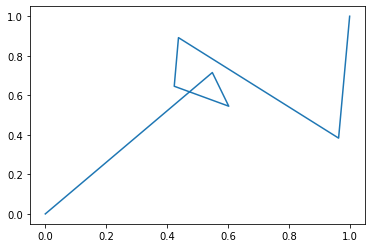



est_cost=0
target_index=0
current_route=[0]
new_route=[0, 1]


est_cost=0.5335600727806402
target_index=1
current_route=[0, 1]
new_route=[0, 1, 2]


est_cost=0.6040929171154337
target_index=2
current_route=[0, 1, 2]
new_route=[0, 1, 2, 3]


est_cost=0.6764353402106725
target_index=3
current_route=[0, 1, 2, 3]
new_route=[0, 1, 2, 3, 4]


est_cost=0.5727313753366328
target_index=4
current_route=[0, 1, 2, 3, 4]
new_route=[0, 1, 2, 3, 4, 5]


est_cost=0.6176283313468298
target_index=5
current_route=[0, 1, 2, 3, 4, 5]
new_route=[0, 1, 2, 3, 4, 5, 6]


est_cost=0.0
target_index=6
current_route=[0, 1, 2, 3, 4, 5, 6]
new node index = 7
links = [2, 5]
costs = [0.18963685 0.2252094 ]
pre_node route list = [[0, 1, 2]]
pre_node route costs = [0.0]
new_route=[0, 1, 2, 7]
pre_node route list = [[0, 1, 2, 3, 4, 5]]
pre_node route costs = [0.0]
new_route=[0, 1, 2, 3, 4, 5, 7]


est_cost=0.704727574774966
target_index=7
current_route=[0, 1, 2, 7]


est_cost=0.7403001227845238
target_index=7
current_r

[[0, 1, 2, 3, 4, 5, 6]]
[0.0]
**************************************************
nearer = [2, 5]
costs = [0.18963685 0.2252094 ]
goal route = [0, 1, 2, 3, 4, 5, 6]
0 links = [1]
1 links = [2]
2 links = [3, 7]
3 links = [4]
4 links = [5]
5 links = [6, 7]
6 links = []
7 links = []


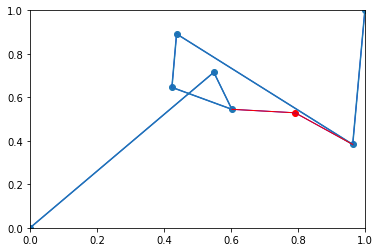

new node index = 8
links = [1, 4]
costs = [0.2112843  0.13477076]
pre_node route list = [[0, 1]]
pre_node route costs = [0.0]
new_route=[0, 1, 8]
pre_node route list = [[0, 1, 2, 3, 4]]
pre_node route costs = [0.0]
new_route=[0, 1, 2, 3, 4, 8]


est_cost=0.5730872713571435
target_index=8
current_route=[0, 1, 2, 3, 4, 8]


est_cost=0.6496008040479664
target_index=8
current_route=[0, 1, 8]


nearer = [1, 4]
costs = [0.2112843  0.13477076]
goal route = [0, 1, 2, 3, 4, 5, 6]
0 links = [1]
1 links = [2, 8]
2 links = [3, 7]
3 links = [4]
4 links = [5, 8]
5 links = [6, 7]
6 links = []
7 links = []
8 links = []


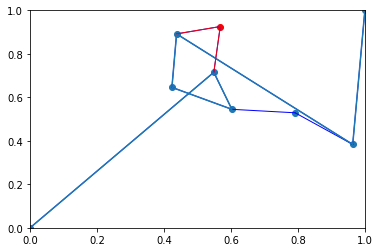

In [99]:
import matplotlib.pyplot as plt
import numpy as np
logger.setLevel(DEBUG)
np.random.seed(0)
NUM = 5
DIM = 2
points = np.random.rand(NUM*DIM).reshape((NUM, DIM)).tolist()
points = [[0,0]] + points
points += [[1, 1]]
for_plots = list(zip(*points))
plt.plot(for_plots[0], for_plots[1])
plt.pause(0.1)

graph = Graph()
for n, node in enumerate(points):
  if n==0:
    graph.add_node_edge(node, [], [])
  else:
    graph.add_node_edge(node, [n-1], [np.linalg.norm(np.array(node) - points[n])])

route, costs = graph.find_shorter_path(0, len(graph.node_list)-1, 2)
print(route)
print(costs)
th_cost = costs[0]

def plotline(p1, p2, new=True):
  color = "red"
  if not new:
    color = "blue"
  plt.plot([p1[0], p2[0]], [p1[1],p2[1]], color=color, linewidth=1)

connect_th_dist = 0.3
tmp_points = list(points)
print("*"*50)
for n in range(2):
  p = np.random.rand(DIM)
  dists = np.array([np.linalg.norm(p - tp) for tp in tmp_points])
  nearer = list(*np.where(dists<connect_th_dist))
  costs = dists[nearer]
  if len(nearer)==0:
    n-=1
    continue
  print("nearer = {}".format(nearer))
  print("costs = {}".format(costs))
  plt.scatter([tp[0] for tp in tmp_points], [tp[1] for tp in tmp_points])
  plt.scatter(p[0], p[1], color="red")
  tmp_points.append(p)
  routes, costs = graph.add_node_edge_and_find_shorter_path(p, nearer, costs, th_cost)

  for route in graph.route_links[graph.goal_index]:
    print("goal route = {}".format(route))

  if len(routes)!=0:
    print("Found new route")
    for route in routes:
      print(route)
    print(costs)
    if len(costs)!=0 and th_costs>costs[0]:
      th_cost = costs[0]

  for idx in range(len(tmp_points)):
    links = graph.get_link_node_idx_list(idx)
    links = [ i for i in links if i>idx]
    print("{} links = {}".format(idx, links))
    for link in links:
      plotline(tmp_points[idx], tmp_points[link], False)

  plt.plot(for_plots[0], for_plots[1])
  if len(routes)!=[]:
    for route in routes:
      plt.plot([tmp_points[idx][0] for idx in route],
              [tmp_points[idx][1] for idx in route])
  for idx in nearer:
    plotline(p, tmp_points[idx])
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.pause(0.1)
